In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import datetime

# Function Definitions

In [107]:
def clean_sub_count(count):
    count = str(count).replace('\xa0',' ')
    if 'Mio.' in count:
        count = int(float(count.split(' ')[0].replace(',','.')) * 1000000)
    elif count == 'nan':
        count = 0
    else:
        count = int(count.split(' ')[0].replace('.',''))
    return count

# Data Preparation

## Data Imports

### Flow Data

In [108]:
flow_predictions = pd.read_csv('../results/yt_analysis/results.csv')
flow_predictions['VID'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
flow_predictions['FRAME'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-4]))
flow_predictions['FLOW_C'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-2]))
flow_predictions.drop(columns=['FILE'], inplace=True)
flow_predictions.loc[flow_predictions['PROB'] >= 0.5, 'FLOW_P_C'] = int(1)
flow_predictions.loc[flow_predictions['PROB'] < 0.5, 'FLOW_P_C'] = int(0)
flow_predictions.rename(columns={'PROB':'FLOW_P'}, inplace=True)
flow_predictions.head(5)

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C
0,0.652541,11,7258,1,1.0
1,0.518073,13,574,0,1.0
2,0.592700,12,6192,0,1.0
3,0.474445,42,7136,0,0.0
4,0.345597,19,1075,0,0.0


### Fer Private

In [109]:
fer_private = pd.read_csv('../results/yt_analysis/FER_results_private.csv').drop(columns=['FLOW'])
fer_private[['PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']] = \
    fer_private['EMO_P'].str.strip('[').str.strip(']').str.split(' ', expand=True).loc[:,0:5].apply(pd.to_numeric, errors='coerce')
fer_private['VID'] = fer_private['VID'].astype('int')
fer_private['FRAME'] = fer_private['FRAME'].astype('int')
fer_private.rename(columns={'EMO_C':'EMO_PRIVATE'}, inplace=True)
emo_private_dummies= pd.get_dummies(fer_private['EMO_PRIVATE'],drop_first=False, prefix='PRIVATE').add_suffix('_C')
fer_private = pd.concat([fer_private, emo_private_dummies],axis=1 )
fer_private.drop(columns=['EMO_P'], inplace=True)
fer_private.head(5)

,VID,FRAME,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,35,4828,neutral,1.060863e-02,5.868053e-04,0.000093,0.697780,0.250793,4.013845e-02,0,0,0,1,0,0
1,10,1000,sad,1.218641e-07,3.595444e-07,0.000002,0.001313,0.998684,4.138556e-07,0,0,0,0,1,0
2,10,1001,sad,7.561166e-07,5.696014e-06,0.000015,0.006154,0.993822,2.700594e-06,0,0,0,0,1,0
3,10,1002,sad,1.872831e-06,9.105769e-06,0.000019,0.051558,0.948405,6.697891e-06,0,0,0,0,1,0
4,10,1003,sad,1.565203e-07,4.356439e-07,0.000002,0.003426,0.996571,7.726713e-07,0,0,0,0,1,0


### Video Stats

In [110]:
video_stats = pd.read_csv('../results/yt_analysis/video_stats_enhanced.csv', sep=',').drop(columns=['url','Frames_CV','commentCount'])
video_stats['Zeit'] = video_stats['Zeit'].apply(lambda x: float(x.replace(',','.')))
video_stats['date_published'] = video_stats['date_published'].apply(lambda x: x.split(' ')[-1])
video_stats['days_published'] = (pd.to_datetime(video_stats['date_published']) - pd.to_datetime(datetime.date.today())).apply(lambda x: x.days * -1)

video_stats['channel_subscribers'] = video_stats['channel_subscribers'].apply(clean_sub_count)

video_stats['likeRatio'] = video_stats['likeCount'] / video_stats['viewCount']
video_stats['dislikeRatio'] = video_stats['dislikeCount'] / video_stats['viewCount']

video_stats['LogLikeCount'] = video_stats['likeCount'].apply(np.log)
video_stats['LogDisLikeCount'] = video_stats['dislikeCount'].apply(np.log1p)
video_stats['LogViewCount'] = video_stats['viewCount'].apply(np.log1p)

video_stats.fillna(0, inplace=True)
video_stats.rename(columns={'Frames':'YT_FRAMES', 'FRAMES_CV':'CVAT_FRAMES', 'Zeit':'VID_LEN'}, inplace=True)
video_stats.head(5)

,id,viewCount,likeCount,dislikeCount,YT_FRAMES,VID_LEN,date_published,duration,channel_subscribers,days_published,likeRatio,dislikeRatio,LogLikeCount,LogDisLikeCount,LogViewCount
0,1,48134273.0,268268.0,6901.0,12150.0,6.75,21.07.2009,0:06,1470000,4124,0.005573,0.000143,12.499742,8.839567,17.689505
1,2,6425717.0,28765.0,1142.0,8280.0,5.75,13.12.2010,5:45,13300,3614,0.004477,0.000178,10.266915,7.041412,15.675819
2,3,28269.0,466.0,8.0,13020.0,7.23,16.12.2018,0:15,1540,689,0.016484,0.000283,6.144186,2.197225,10.249556
3,4,1862525.0,28179.0,247.0,5940.0,3.30,04.05.2018,0:30,1110000,944,0.015129,0.000133,10.246332,5.513429,14.437444
4,5,4427177.0,52880.0,942.0,5976.0,4.15,21.01.2015,0:30,59400,2114,0.011944,0.000213,10.875780,6.849066,15.303273


## Merging

In [111]:
full_df = flow_predictions.merge(fer_private, on=['VID','FRAME'])
full_df.fillna(0, inplace=True)
full_df.head(5)


,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,0.652541,11,7258,1,1.0,neutral,0.000181,0.000250,0.000006,0.993061,0.000229,0.006274,0,0,0,1,0,0
1,0.518073,13,574,0,1.0,sad,0.000427,0.000091,0.000173,0.024299,0.974595,0.000416,0,0,0,0,1,0
2,0.592700,12,6192,0,1.0,neutral,0.001214,0.000314,0.000592,0.927147,0.069780,0.000953,0,0,0,1,0,0
3,0.474445,42,7136,0,0.0,sad,0.000025,0.000007,0.000897,0.274898,0.722561,0.001612,0,0,0,0,1,0
4,0.345597,19,1075,0,0.0,neutral,0.001108,0.000022,0.000221,0.993751,0.004663,0.000236,0,0,0,1,0,0


In [112]:
grouped_pred = full_df.groupby('VID', as_index=False).agg({'FLOW_P': 'mean',
                                                           'FRAME': 'count',
                                                           'FLOW_C': 'mean',
                                                           'FLOW_P_C': 'mean',
                                                           'PRIVATE_ANGRY_P':'mean',
                                                           'PRIVATE_FEAR_P':'mean',
                                                           'PRIVATE_HAPPY_P':'mean',
                                                           'PRIVATE_NEUTRAL_P':'mean',
                                                           'PRIVATE_SAD_P':'mean',
                                                           'PRIVATE_SURPRISE_P':'mean',
                                                           'PRIVATE_angry_C':'mean',
                                                           'PRIVATE_fear_C':'mean',
                                                           'PRIVATE_happy_C':'mean',
                                                           'PRIVATE_neutral_C':'mean',
                                                           'PRIVATE_sad_C':'mean',
                                                           'PRIVATE_surprise_C':'mean'
                                                           })
grouped_pred.head(5)

,VID,FLOW_P,FRAME,FLOW_C,FLOW_P_C,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,1,0.532123,3098,0.624274,0.684635,0.004064,0.000638,0.260027,0.495626,0.202225,0.036449,0.002582,0.000323,0.266946,0.505165,0.191414,0.033570
1,2,0.419141,2192,0.098540,0.208942,0.000136,0.009324,0.107770,0.829276,0.021366,0.032024,0.000000,0.007755,0.106752,0.840328,0.018704,0.026460
2,3,0.462950,976,0.408811,0.287910,0.032130,0.043656,0.141738,0.490995,0.267282,0.021835,0.029713,0.048156,0.140369,0.493852,0.270492,0.017418
3,4,0.447481,3343,0.307508,0.049656,0.000508,0.000061,0.000762,0.717408,0.281043,0.000212,0.000000,0.000000,0.000000,0.725396,0.274604,0.000000
4,5,0.393559,1378,0.347605,0.038462,0.000489,0.003466,0.407668,0.424203,0.159622,0.003101,0.000000,0.000726,0.410015,0.433962,0.152395,0.002903


In [113]:
final_data = video_stats.merge(grouped_pred, how='inner', left_on='id', right_on='VID').drop(columns=['VID'])
final_data['USED_PROPORTION'] = final_data['FRAME'] / final_data['YT_FRAMES']
final_data.head(5)

,id,viewCount,likeCount,dislikeCount,YT_FRAMES,VID_LEN,date_published,duration,channel_subscribers,days_published,...,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C,USED_PROPORTION
0,1,48134273.0,268268.0,6901.0,12150.0,6.75,21.07.2009,0:06,1470000,4124,...,0.495626,0.202225,0.036449,0.002582,0.000323,0.266946,0.505165,0.191414,0.033570,0.254979
1,2,6425717.0,28765.0,1142.0,8280.0,5.75,13.12.2010,5:45,13300,3614,...,0.829276,0.021366,0.032024,0.000000,0.007755,0.106752,0.840328,0.018704,0.026460,0.264734
2,3,28269.0,466.0,8.0,13020.0,7.23,16.12.2018,0:15,1540,689,...,0.490995,0.267282,0.021835,0.029713,0.048156,0.140369,0.493852,0.270492,0.017418,0.074962
3,4,1862525.0,28179.0,247.0,5940.0,3.30,04.05.2018,0:30,1110000,944,...,0.717408,0.281043,0.000212,0.000000,0.000000,0.000000,0.725396,0.274604,0.000000,0.562795
4,5,4427177.0,52880.0,942.0,5976.0,4.15,21.01.2015,0:30,59400,2114,...,0.424203,0.159622,0.003101,0.000000,0.000726,0.410015,0.433962,0.152395,0.002903,0.230589


# Analysis

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='likeCount', ylabel='Density'>

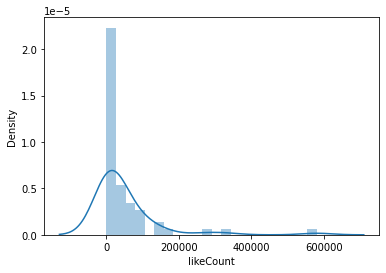

In [114]:
sns.distplot(final_data['likeCount'])

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LogLikeCount', ylabel='Density'>

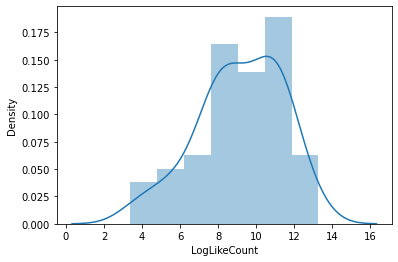

In [115]:
sns.distplot(final_data['LogLikeCount'])

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)


                                 OLS Regression Results                                
Dep. Variable:           LogLikeCount   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              215.8
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                    2.52e-29
Time:                        12:12:23   Log-Likelihood:                         -125.46
No. Observations:                  56   AIC:                                      258.9
Df Residuals:                      52   BIC:                                      267.0
Df Model:                           4                                                  
Covariance Type:                  hc3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

<Figure size 1080x720 with 0 Axes>

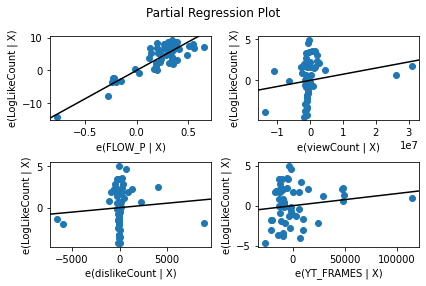

In [116]:
X = final_data[['FLOW_P', 'viewCount','dislikeCount','YT_FRAMES']]
y = final_data['LogLikeCount']


model = sm.OLS(y,X)
model = model.fit(cov_type='hc3')
print(model.summary())

fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)


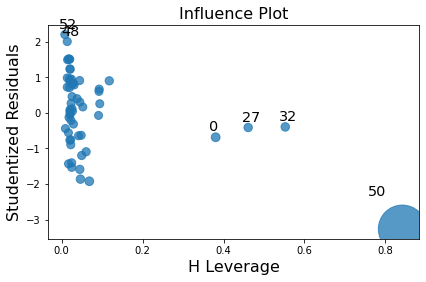

In [117]:
fig = sm.graphics.influence_plot(model)
fig.tight_layout(pad=1.0)
